In [1]:
%matplotlib inline
from common_imports import *

Couldn't import dot_parser, loading of dot files will not be possible.


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Define Tasks

In [2]:
H = W = 10
grid = np.zeros((H, W))
goal = {(W-1, H-1): 1.}

pos_list = []
for h in range(0, H):
    for w in range(0, W):
        if (w, h) in goal:
            continue
        pos_list.append((w, h))

tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal=goal, rewards=goal, wall_penalty=0.)
         for pos in pos_list]
tasks_by_pos = {task.start_pos: task for task in tasks}
random.shuffle(tasks)

test_pos_list = [(0,0), (3,3), (6,6), (8,8)]
test_tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal=goal, rewards=goal, wall_penalty=0.)
         for pos in test_pos_list]
task0 = tasks[0]

In [3]:
# create the task.
state_shape = task0.state_shape
task = task0
# define potential neural network architectures.
def two_layer(states):
    '''
    two layer neural network with same number of hidden units.
    '''
    state_vecs = states.flatten(2)
    return arch.two_layer(state_vecs, np.prod(task.state_shape), 128, task.num_actions)





# Kernels and Expansions

In [4]:
def mf_xy(task):
    return np.array([task.start_pos[0], task.start_pos[1]])

def kernel_func(task_i, task_j):
    feat_i = mf_xy(task_i)
    feat_j = mf_xy(task_j)
    return np.exp(1 - 1 * np.sum(np.abs(feat_i - feat_j)))

In [5]:
def expand_func(task):
    (x,y) = task.start_pos
    new_tasks = []
    for xs in [-1, 0, 1]:
        for ys in [-1, 0, 1]:
            pos = (x + xs, y + ys)
            if pos in tasks_by_pos:
                new_tasks.append(tasks_by_pos[pos])
    return new_tasks

In [6]:
expand_func(tasks_by_pos[(8,9)])

[(7, 8) -> (9, 9),
 (7, 9) -> (9, 9),
 (8, 8) -> (9, 9),
 (8, 9) -> (9, 9),
 (9, 8) -> (9, 9)]

## Utils

In [7]:
def plot_scores():
    keys = scores[0].keys()
    xs = exs
    for key in keys:
        ys = [score[key] for score in scores]
        plot(xs, ys)
    legend(keys)
    show()

# Train and Eval funcs

### V0

In [22]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)

In [23]:
budget = 5
tol = 1e-4
gamma = 0.9
memory_size = 128
lr = 1e-3

learner = DeepQlearnMT(dqn, gamma=gamma, lr=lr, memory_size=memory_size, epsilon=0.1)
train_func = lambda task:  learner.run(task, num_episodes=1, tol=tol, budget=budget)
eval_func = lambda task: qval_stochastic(dqn, task, gamma=gamma, budget=budget, num_trials=100, tol=tol)

In [24]:
meta = GPv0(dqn, kernel_func, expand_func, train_func, eval_func, 
            eta=1/20., sigma_n=0.01, K0=10, K=1)

In [25]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(100):
    meta.run(tasks, num_epochs=1)
    to_show = ['new-tasks-selected', 'im', 'pred', 'ucb']
    pprint({key: meta.diagnostics[key] for key in to_show})
    print '---------------------------------------'
    if (it + 1) % 10 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

{'im': {(4, 1) -> (9, 9): 3.4810113944593046e-05,
        (3, 2) -> (9, 9): -2.4031838164566277e-06,
        (5, 3) -> (9, 9): 3.6626559098232661e-05,
        (9, 3) -> (9, 9): 8.7833735798953719e-05,
        (0, 4) -> (9, 9): 2.4895955171755964e-05,
        (4, 7) -> (9, 9): 0.00011470521696449855,
        (3, 8) -> (9, 9): 6.2257679033562476e-06,
        (9, 8) -> (9, 9): -0.060118965400195457,
        (4, 9) -> (9, 9): -8.0128450943038176e-05},
 'new-tasks-selected': [(1, 5) -> (9, 9)],
 'pred': {(3, 0) -> (9, 9): 3.627359033592138e-06,
          (4, 0) -> (9, 9): 1.2805468146110089e-05,
          (5, 0) -> (9, 9): 6.1569811011212846e-06,
          (2, 1) -> (9, 9): 3.7708529424435775e-06,
          (3, 1) -> (9, 9): 9.8601841463102732e-06,
          (5, 1) -> (9, 9): 1.6736409845343746e-05,
          (2, 2) -> (9, 9): -4.9389347159026388e-07,
          (4, 2) -> (9, 9): 1.5231309928839512e-05,
          (5, 2) -> (9, 9): 1.6288693174689296e-05,
          (6, 2) -> (9, 9): 7.3728409

In [20]:
RenderJSON({key: str(meta.diagnostics[key]) for key in to_show})

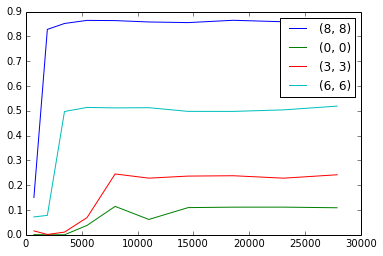

In [26]:
plot_scores()

### V0a

In [46]:
def visualize_tasks(active_tasks, passive_tasks):
    arr = np.zeros((H, W))
    for task in active_tasks:
        arr[task.start_pos] = 1.
    for task in passive_tasks:
        arr[task.start_pos] = -1.
    imshow(arr, interpolation='none')
    show()

def get_globals(*keys):
    result = {}
    if not keys:
        result.update(globals())
    else:
        result.update({
                key:globals()[key]
                for key in keys
            })
    return result

def save_globals(name, keys):
    global global_results
    if 'global_results' not in globals():
        global_results = {}
    global_results[name] = get_globals(*keys)

def save_results():
    global global_results
    with open('result-dot-at-corner-gp') as f:
        pickle.dump(global_results, f)

def plot_mean_scores(names):
    global global_results
    results = []
    tasks = {}
    figure(1, figsize=(20, 20))
    for name in names:
        result = global_results[name]
        results.append(result)
        tasks = result['scores'][0].keys()
    
    num_tasks = len(tasks)
    H = np.ceil(np.sqrt(num_tasks))
    for (ti, task) in enumerate(tasks):
        subplot(H, H, ti + 1)
        for result in results:
            plot(result['exs'], [t[task] for t in result['scores']])
        legend(names)
    
        xlabel('number of experiences')
        ylabel('score')
        title(task)
    
    show()

In [47]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)
budget = 20
tol = 1e-4
gamma = 0.9
memory_size = 128
lr = 1e-3

learner = DeepQlearnMT(dqn, gamma=gamma, lr=lr, memory_size=memory_size, epsilon=0.1)
train_func = lambda task:  learner.run(task, num_episodes=1, tol=tol, budget=budget)
eval_func = lambda task: qval_stochastic(dqn, task, gamma=gamma, budget=budget, num_trials=100, tol=tol)

meta = GPv0a(dqn, kernel_func, expand_func, train_func, eval_func, 
            eta=1e-4, sigma_n=0.01, K=5, K0=1)

{'im': {(7, 0) -> (9, 9): -0.025938140522352722,
        (2, 1) -> (9, 9): 5.5823773230423033e-05,
        (7, 1) -> (9, 9): -0.033927753224057423,
        (8, 1) -> (9, 9): -0.14196314605569463,
        (3, 6) -> (9, 9): -0.00016394620757920403,
        (0, 8) -> (9, 9): 5.861110455668804e-05},
 'new-tasks-selected': [(0, 9) -> (9, 9),
                        (1, 1) -> (9, 9),
                        (2, 2) -> (9, 9),
                        (0, 7) -> (9, 9),
                        (1, 8) -> (9, 9),
                        (3, 0) -> (9, 9)],
 'pred': {(1, 0) -> (9, 9): -2.5793918104900971e-05,
          (2, 0) -> (9, 9): -7.0132451506887812e-05,
          (3, 0) -> (9, 9): -0.00043692645118030462,
          (6, 0) -> (9, 9): -0.0095402557306743917,
          (7, 0) -> (9, 9): -0.0259375680296846,
          (8, 0) -> (9, 9): -0.057173438418167667,
          (9, 0) -> (9, 9): -0.021032932575125392,
          (1, 1) -> (9, 9): 2.0549876416248425e-05,
          (2, 1) -> (9, 9): 5.581329

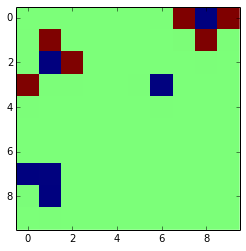

---------------------------------------
total_exp 120
{'im': {(3, 0) -> (9, 9): -0.0001313910085916148,
        (7, 0) -> (9, 9): -0.00015526946683551353,
        (1, 1) -> (9, 9): -0.000117635400767711,
        (2, 1) -> (9, 9): -0.0001079222757378382,
        (7, 1) -> (9, 9): -0.00016879766894511571,
        (8, 1) -> (9, 9): -0.00015762861984526652,
        (2, 2) -> (9, 9): -9.8463482042626378e-05,
        (3, 6) -> (9, 9): -9.6328534169808609e-05,
        (0, 7) -> (9, 9): -0.00010840728431696774,
        (0, 8) -> (9, 9): -0.00012860580254931602,
        (1, 8) -> (9, 9): -0.00010305203010784814,
        (0, 9) -> (9, 9): -0.00014916987533447238},
 'new-tasks-selected': [(4, 5) -> (9, 9),
                        (4, 7) -> (9, 9),
                        (2, 5) -> (9, 9),
                        (0, 0) -> (9, 9),
                        (9, 2) -> (9, 9),
                        (0, 3) -> (9, 9)],
 'pred': {(1, 0) -> (9, 9): -5.7082205105959933e-05,
          (0, 0) -> (9, 9): -2.

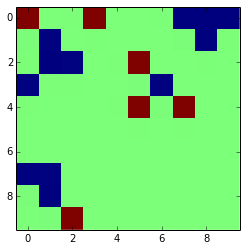

---------------------------------------
total_exp 240
{'im': {(0, 0) -> (9, 9): -1.0525824671556193e-05,
        (3, 0) -> (9, 9): 2.8503206326377731e-05,
        (7, 0) -> (9, 9): 8.0510880740916396e-05,
        (1, 1) -> (9, 9): -1.5137039004253956e-05,
        (2, 1) -> (9, 9): 1.0293886594607549e-05,
        (7, 1) -> (9, 9): 0.00010231303823440163,
        (8, 1) -> (9, 9): 9.4781496310203763e-05,
        (2, 2) -> (9, 9): 2.2113879154964143e-05,
        (9, 2) -> (9, 9): 8.3217451870220725e-05,
        (0, 3) -> (9, 9): -1.9250839650343239e-05,
        (2, 5) -> (9, 9): -3.1814259920828585e-05,
        (4, 5) -> (9, 9): 6.1566222514069222e-05,
        (3, 6) -> (9, 9): -1.8631858601315986e-05,
        (0, 7) -> (9, 9): -3.2596686208802425e-05,
        (4, 7) -> (9, 9): -1.1616732616046813e-05,
        (0, 8) -> (9, 9): -7.8374083651291601e-06,
        (1, 8) -> (9, 9): -1.734349934827276e-05,
        (0, 9) -> (9, 9): 4.5371055124081511e-06},
 'new-tasks-selected': [(8, 2) -> (9,

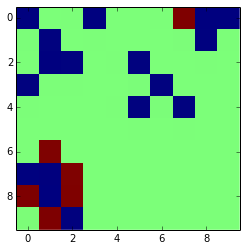

---------------------------------------
total_exp 360
{'im': {(0, 0) -> (9, 9): -7.6869863193913698e-05,
        (3, 0) -> (9, 9): -0.00014198031533357725,
        (7, 0) -> (9, 9): -0.00021804154737989172,
        (8, 0) -> (9, 9): -0.00023339939615535591,
        (1, 1) -> (9, 9): -8.8019643963514158e-05,
        (2, 1) -> (9, 9): -0.00014022328784782484,
        (6, 1) -> (9, 9): -0.00020513012823808956,
        (7, 1) -> (9, 9): -0.00023752217417292496,
        (8, 1) -> (9, 9): -0.00023066344998696673,
        (9, 1) -> (9, 9): -0.00020311416939632586,
        (2, 2) -> (9, 9): -0.00015608031042196137,
        (7, 2) -> (9, 9): -0.000206756532687739,
        (8, 2) -> (9, 9): -0.0002116955155272454,
        (9, 2) -> (9, 9): -0.00020624413619193421,
        (0, 3) -> (9, 9): -0.00011395383266803524,
        (2, 5) -> (9, 9): -0.00014069026463852055,
        (4, 5) -> (9, 9): -0.00018078648057114825,
        (3, 6) -> (9, 9): -0.0001327177582487333,
        (0, 7) -> (9, 9): -0.000

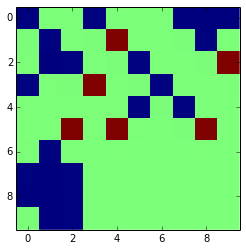

---------------------------------------
total_exp 480
{'im': {(0, 0) -> (9, 9): -0.00014534693897255748,
        (3, 0) -> (9, 9): -0.0001378067552283585,
        (7, 0) -> (9, 9): -0.00011640730926604952,
        (8, 0) -> (9, 9): -0.00011362389185915796,
        (1, 1) -> (9, 9): -0.00013532163389263732,
        (2, 1) -> (9, 9): -0.00012742043871252472,
        (6, 1) -> (9, 9): -0.00011981928604273613,
        (7, 1) -> (9, 9): -0.00012941640608379705,
        (8, 1) -> (9, 9): -0.00012214988802569744,
        (9, 1) -> (9, 9): -0.00012681798706250328,
        (2, 2) -> (9, 9): -0.00012560157215211221,
        (5, 2) -> (9, 9): -0.00012438163980972307,
        (7, 2) -> (9, 9): -0.0001161376947441277,
        (8, 2) -> (9, 9): -0.00011704833948897717,
        (9, 2) -> (9, 9): -0.00012642971982684153,
        (0, 3) -> (9, 9): -0.00010690275498381128,
        (3, 3) -> (9, 9): -0.00012340143154363333,
        (1, 4) -> (9, 9): -0.0001093103485569402,
        (5, 4) -> (9, 9): -0.00

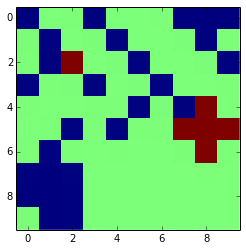

---------------------------------------
total_exp 600
{'im': {(0, 0) -> (9, 9): 3.9672520507469803e-05,
        (3, 0) -> (9, 9): 5.539598926796058e-05,
        (7, 0) -> (9, 9): 4.6108663288382538e-05,
        (8, 0) -> (9, 9): 4.710299305000106e-05,
        (1, 1) -> (9, 9): 4.202616551720165e-05,
        (2, 1) -> (9, 9): 5.9521836639007383e-05,
        (6, 1) -> (9, 9): 4.1682272193369188e-05,
        (7, 1) -> (9, 9): 5.7615266390315483e-05,
        (8, 1) -> (9, 9): 5.2340576104175721e-05,
        (9, 1) -> (9, 9): 5.3696456450379158e-05,
        (2, 2) -> (9, 9): 5.8686956773615481e-05,
        (5, 2) -> (9, 9): 5.3905179165516644e-05,
        (7, 2) -> (9, 9): 4.1737003643484478e-05,
        (8, 2) -> (9, 9): 4.7572468297754414e-05,
        (9, 2) -> (9, 9): 4.1774476227766176e-05,
        (0, 3) -> (9, 9): 6.4521640768001024e-05,
        (3, 3) -> (9, 9): 5.5528061958476734e-05,
        (1, 4) -> (9, 9): 4.4447464025041119e-05,
        (5, 4) -> (9, 9): 0.00010999335433093113,

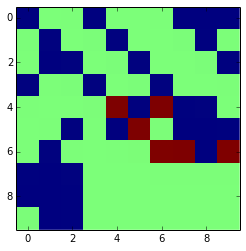

---------------------------------------
total_exp 720
{'im': {(0, 0) -> (9, 9): -3.0715952737906532e-06,
        (3, 0) -> (9, 9): -5.5935522298349114e-06,
        (7, 0) -> (9, 9): 8.2748904301037645e-07,
        (8, 0) -> (9, 9): -1.8971924494210087e-05,
        (1, 1) -> (9, 9): -1.2220132619522611e-05,
        (2, 1) -> (9, 9): -1.0380356948513409e-05,
        (6, 1) -> (9, 9): 6.4755813335177093e-06,
        (7, 1) -> (9, 9): -7.0451322378894189e-06,
        (8, 1) -> (9, 9): -1.0519343621934291e-05,
        (9, 1) -> (9, 9): -1.2515356168730235e-05,
        (2, 2) -> (9, 9): 1.8019062312716163e-07,
        (5, 2) -> (9, 9): 8.8391318477382813e-06,
        (7, 2) -> (9, 9): 2.7722556514534098e-06,
        (8, 2) -> (9, 9): -9.2860164965704049e-06,
        (9, 2) -> (9, 9): -1.9724683888798066e-06,
        (0, 3) -> (9, 9): -1.5314059201103976e-05,
        (3, 3) -> (9, 9): -5.8408712569548316e-06,
        (1, 4) -> (9, 9): 7.6769192257672669e-06,
        (4, 4) -> (9, 9): -1.54683

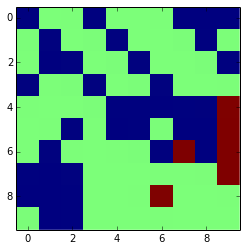

---------------------------------------
total_exp 840
{'im': {(0, 0) -> (9, 9): 4.1498134479813693e-05,
        (3, 0) -> (9, 9): 2.5884214682765026e-05,
        (7, 0) -> (9, 9): 3.5588852670874119e-05,
        (8, 0) -> (9, 9): 4.9241376706719514e-05,
        (1, 1) -> (9, 9): 4.9097697794376813e-05,
        (2, 1) -> (9, 9): 2.1221323501333637e-05,
        (6, 1) -> (9, 9): 2.8315718360354074e-05,
        (7, 1) -> (9, 9): 3.588073019193925e-05,
        (8, 1) -> (9, 9): 4.5546143244899192e-05,
        (9, 1) -> (9, 9): 4.0820299753790846e-05,
        (2, 2) -> (9, 9): 2.2531818686188942e-05,
        (5, 2) -> (9, 9): 2.0036491842595619e-05,
        (7, 2) -> (9, 9): 3.1580925201190813e-05,
        (8, 2) -> (9, 9): 3.4724480922176853e-05,
        (9, 2) -> (9, 9): 3.4677410632378192e-05,
        (0, 3) -> (9, 9): 3.2173920940119769e-05,
        (3, 3) -> (9, 9): 1.9714431502410539e-05,
        (1, 4) -> (9, 9): 3.1662051721954312e-05,
        (4, 4) -> (9, 9): 0.0022968208671488321

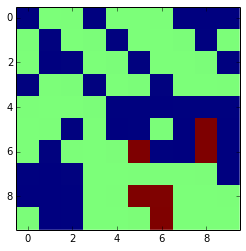

---------------------------------------
total_exp 960
{'im': {(0, 0) -> (9, 9): -5.4927144591768271e-05,
        (3, 0) -> (9, 9): -4.0540139653236161e-05,
        (7, 0) -> (9, 9): -5.4562783908243491e-05,
        (8, 0) -> (9, 9): -5.6268008556303517e-05,
        (1, 1) -> (9, 9): -5.3408039535606723e-05,
        (2, 1) -> (9, 9): -3.8477894461201508e-05,
        (6, 1) -> (9, 9): -5.1446569474254369e-05,
        (7, 1) -> (9, 9): -5.7769922865568668e-05,
        (8, 1) -> (9, 9): -5.5100871767193519e-05,
        (9, 1) -> (9, 9): -5.7657323961676448e-05,
        (2, 2) -> (9, 9): -4.6902742820438507e-05,
        (5, 2) -> (9, 9): -4.6529595139472224e-05,
        (7, 2) -> (9, 9): -4.9096094233737992e-05,
        (8, 2) -> (9, 9): -5.2399979025743949e-05,
        (9, 2) -> (9, 9): -5.1092468473228598e-05,
        (0, 3) -> (9, 9): -3.6276686595562892e-05,
        (3, 3) -> (9, 9): -4.9560299435220441e-05,
        (1, 4) -> (9, 9): -3.9014312374197136e-05,
        (4, 4) -> (9, 9): -0

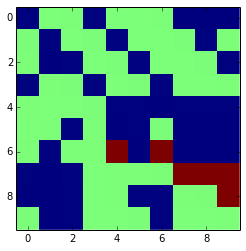

---------------------------------------
total_exp 1080
{'im': {(0, 0) -> (9, 9): 0.003589731476015321,
        (3, 0) -> (9, 9): 0.0036191111363349892,
        (7, 0) -> (9, 9): 0.0035892574328194125,
        (8, 0) -> (9, 9): 0.0035543350839676272,
        (1, 1) -> (9, 9): 0.0035845928586915082,
        (2, 1) -> (9, 9): 0.0035895121062957764,
        (6, 1) -> (9, 9): 0.003607799428188545,
        (7, 1) -> (9, 9): 0.0035744195180435904,
        (8, 1) -> (9, 9): 0.0035348527350010824,
        (9, 1) -> (9, 9): 0.0035335571920830592,
        (2, 2) -> (9, 9): 0.0035935037353143199,
        (5, 2) -> (9, 9): 0.0036092585833285016,
        (7, 2) -> (9, 9): 0.0036018584662738154,
        (8, 2) -> (9, 9): 0.0035373458606912109,
        (9, 2) -> (9, 9): 0.0035416188788260027,
        (0, 3) -> (9, 9): 0.0035623791657038348,
        (3, 3) -> (9, 9): 0.0036036032449023366,
        (1, 4) -> (9, 9): 0.0035712464750428555,
        (4, 4) -> (9, 9): 0.0036299874715634089,
        (5, 4) -

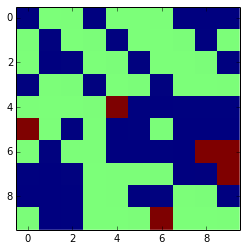

---------------------------------------
total_exp 1183
{'im': {(0, 0) -> (9, 9): -0.0011744546891351844,
        (3, 0) -> (9, 9): -0.0012214849164448888,
        (5, 0) -> (9, 9): -0.00088100504323381911,
        (7, 0) -> (9, 9): -0.0006394265444714586,
        (8, 0) -> (9, 9): -0.00060137802029411411,
        (1, 1) -> (9, 9): -0.0011891781236217968,
        (2, 1) -> (9, 9): -0.0012148977521566511,
        (6, 1) -> (9, 9): -0.00069481641811949,
        (7, 1) -> (9, 9): -0.00062728905347690916,
        (8, 1) -> (9, 9): -0.00063741183807783765,
        (9, 1) -> (9, 9): -0.00058900080397033747,
        (2, 2) -> (9, 9): -0.0012171749518582876,
        (5, 2) -> (9, 9): -0.00089352526655952754,
        (7, 2) -> (9, 9): -0.00062773447604107073,
        (8, 2) -> (9, 9): -0.00059879955008283791,
        (9, 2) -> (9, 9): -0.00068849300182057677,
        (0, 3) -> (9, 9): -0.00116932178790276,
        (3, 3) -> (9, 9): -0.0011824437357456905,
        (1, 4) -> (9, 9): -0.00119762809

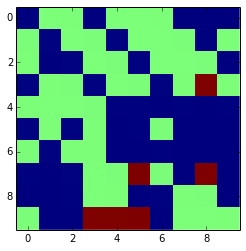

---------------------------------------
total_exp 1303
{'im': {(0, 0) -> (9, 9): 0.0212527356180242,
        (3, 0) -> (9, 9): 0.021397115098442856,
        (5, 0) -> (9, 9): 0.021161145578952101,
        (7, 0) -> (9, 9): 0.021254940095352681,
        (8, 0) -> (9, 9): 0.021425901233662527,
        (1, 1) -> (9, 9): 0.021408344291668765,
        (2, 1) -> (9, 9): 0.021465740562144526,
        (6, 1) -> (9, 9): 0.021283669318154008,
        (7, 1) -> (9, 9): 0.021584619494434614,
        (8, 1) -> (9, 9): 0.02152424244178084,
        (9, 1) -> (9, 9): 0.021076769455157809,
        (2, 2) -> (9, 9): 0.021373716407820063,
        (5, 2) -> (9, 9): 0.021322655881092809,
        (7, 2) -> (9, 9): 0.02157714169509041,
        (8, 2) -> (9, 9): 0.021407501110672258,
        (9, 2) -> (9, 9): 0.021445547174706401,
        (0, 3) -> (9, 9): 0.021318189621223158,
        (3, 3) -> (9, 9): 0.021407018016800269,
        (9, 3) -> (9, 9): 0.021505440737620375,
        (1, 4) -> (9, 9): 0.021397366

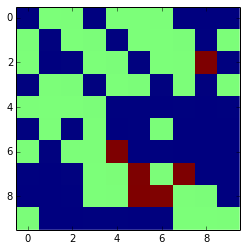

---------------------------------------
total_exp 1406
{'im': {(0, 0) -> (9, 9): 0.012431884307768187,
        (3, 0) -> (9, 9): 0.069174712157044627,
        (5, 0) -> (9, 9): 0.15856906366529772,
        (7, 0) -> (9, 9): 0.21766387160868098,
        (8, 0) -> (9, 9): 0.26087193715093115,
        (1, 1) -> (9, 9): 0.025029539129844409,
        (2, 1) -> (9, 9): 0.034556829095873161,
        (6, 1) -> (9, 9): 0.22709275485024263,
        (7, 1) -> (9, 9): 0.26089196462464548,
        (8, 1) -> (9, 9): 0.29560866796994223,
        (9, 1) -> (9, 9): 0.31260503705166742,
        (2, 2) -> (9, 9): 0.050576640975432671,
        (5, 2) -> (9, 9): 0.22873118635891621,
        (7, 2) -> (9, 9): 0.29143712353670959,
        (8, 2) -> (9, 9): 0.34410746398545422,
        (9, 2) -> (9, 9): 0.40355355926963093,
        (0, 3) -> (9, 9): 0.019636846750494,
        (3, 3) -> (9, 9): 0.087317891849453669,
        (9, 3) -> (9, 9): 0.44555993467120725,
        (1, 4) -> (9, 9): 0.061829921322427289,


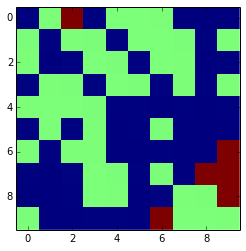

---------------------------------------
total_exp 1503
{'im': {(0, 0) -> (9, 9): -0.015845560472682395,
        (3, 0) -> (9, 9): -0.071288300253246895,
        (5, 0) -> (9, 9): -0.15945069508815118,
        (7, 0) -> (9, 9): -0.21763201378722638,
        (8, 0) -> (9, 9): -0.25881653912435548,
        (1, 1) -> (9, 9): -0.028392294977467061,
        (2, 1) -> (9, 9): -0.037293935911933432,
        (6, 1) -> (9, 9): -0.22819597720666732,
        (7, 1) -> (9, 9): -0.2610105586128561,
        (8, 1) -> (9, 9): -0.29615846842075066,
        (9, 1) -> (9, 9): -0.31266971510435054,
        (0, 2) -> (9, 9): -0.023259887749256577,
        (2, 2) -> (9, 9): -0.052978510681933919,
        (5, 2) -> (9, 9): -0.22980009218574926,
        (7, 2) -> (9, 9): -0.29230385033837758,
        (8, 2) -> (9, 9): -0.34404218684211263,
        (9, 2) -> (9, 9): -0.40370622630627856,
        (0, 3) -> (9, 9): -0.023183992834919599,
        (3, 3) -> (9, 9): -0.084128985705024792,
        (9, 3) -> (9, 9): 

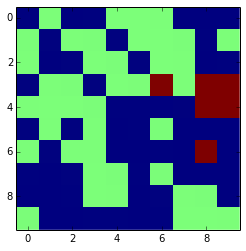

---------------------------------------
total_exp 1541
{'im': {(0, 0) -> (9, 9): -0.002214410989703923,
        (3, 0) -> (9, 9): -0.0030953252893027063,
        (5, 0) -> (9, 9): -0.0011488273690781099,
        (7, 0) -> (9, 9): 0.00073341070104458728,
        (8, 0) -> (9, 9): -0.0025685471935959665,
        (1, 1) -> (9, 9): -0.0024295761527554464,
        (2, 1) -> (9, 9): -0.0030283139736015929,
        (6, 1) -> (9, 9): 0.0051407664043162521,
        (7, 1) -> (9, 9): -0.00037805953052181054,
        (8, 1) -> (9, 9): -0.00059606734476547879,
        (9, 1) -> (9, 9): -0.00010211001035048337,
        (0, 2) -> (9, 9): -0.0024349454267886608,
        (2, 2) -> (9, 9): -0.0030137897920326541,
        (5, 2) -> (9, 9): -0.0011918270736089136,
        (7, 2) -> (9, 9): 0.0028993093203209634,
        (8, 2) -> (9, 9): -0.00050893319925797084,
        (9, 2) -> (9, 9): 0.00025453148024839889,
        (0, 3) -> (9, 9): -0.0022579852740358362,
        (3, 3) -> (9, 9): -0.008186399697487

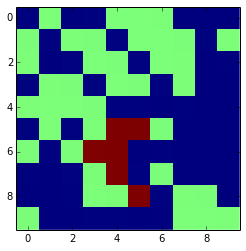

---------------------------------------
total_exp 1621
{'im': {(0, 0) -> (9, 9): -0.00039442690956748017,
        (3, 0) -> (9, 9): 0.039128081102099851,
        (5, 0) -> (9, 9): 0.090695585245182286,
        (7, 0) -> (9, 9): 0.091061704262143259,
        (8, 0) -> (9, 9): 0.1280691175621631,
        (1, 1) -> (9, 9): 0.0056761317455990175,
        (2, 1) -> (9, 9): 0.016887713719334688,
        (6, 1) -> (9, 9): 0.11054971083528506,
        (7, 1) -> (9, 9): 0.13163632980308146,
        (8, 1) -> (9, 9): 0.13638079779832391,
        (9, 1) -> (9, 9): 0.15233355879976768,
        (0, 2) -> (9, 9): 4.8301319632917949e-05,
        (2, 2) -> (9, 9): 0.024327122720394827,
        (5, 2) -> (9, 9): 0.11880054379129142,
        (7, 2) -> (9, 9): 0.16613942292350459,
        (8, 2) -> (9, 9): 0.15354731276544759,
        (9, 2) -> (9, 9): 0.17237356633719383,
        (0, 3) -> (9, 9): 0.00086860558992658127,
        (3, 3) -> (9, 9): 0.080355104743294825,
        (6, 3) -> (9, 9): 0.1591224

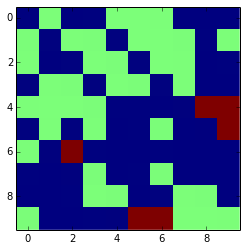

---------------------------------------
total_exp 1703
{'im': {(0, 0) -> (9, 9): 0.002977001249360893,
        (3, 0) -> (9, 9): -0.036832330289530951,
        (5, 0) -> (9, 9): -0.090411787353925008,
        (7, 0) -> (9, 9): -0.090761938951885376,
        (8, 0) -> (9, 9): -0.12751531901092159,
        (1, 1) -> (9, 9): -0.0029440293658016294,
        (2, 1) -> (9, 9): -0.014217027252059092,
        (6, 1) -> (9, 9): -0.11545207219037487,
        (7, 1) -> (9, 9): -0.12944503477483207,
        (8, 1) -> (9, 9): -0.13516120525304554,
        (9, 1) -> (9, 9): -0.15152343055828743,
        (0, 2) -> (9, 9): 0.0026579337044921221,
        (2, 2) -> (9, 9): -0.021940083160872464,
        (5, 2) -> (9, 9): -0.10205683740381805,
        (6, 2) -> (9, 9): -0.12824356906416751,
        (7, 2) -> (9, 9): -0.16097699930163681,
        (8, 2) -> (9, 9): -0.15290861990364985,
        (9, 2) -> (9, 9): -0.17213015841813867,
        (0, 3) -> (9, 9): 0.0017782980156862589,
        (3, 3) -> (9, 9)

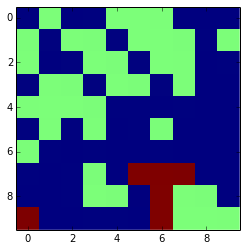

---------------------------------------
total_exp 1755
{'im': {(0, 0) -> (9, 9): 0.069961684487958697,
        (3, 0) -> (9, 9): 0.11046448742647337,
        (5, 0) -> (9, 9): 0.1209978873279106,
        (7, 0) -> (9, 9): 0.15027891806238194,
        (8, 0) -> (9, 9): 0.18891985293298927,
        (9, 0) -> (9, 9): 0.24661568368833411,
        (1, 1) -> (9, 9): 0.10494791431505952,
        (2, 1) -> (9, 9): 0.10957717164418845,
        (6, 1) -> (9, 9): 0.12739134289230919,
        (7, 1) -> (9, 9): 0.14610073972234741,
        (8, 1) -> (9, 9): 0.21021096829710773,
        (9, 1) -> (9, 9): 0.28453717135749673,
        (0, 2) -> (9, 9): 0.070601533168858019,
        (2, 2) -> (9, 9): 0.11645087215193528,
        (5, 2) -> (9, 9): 0.10845636746508214,
        (6, 2) -> (9, 9): 0.12347967516724045,
        (7, 2) -> (9, 9): 0.1577826496386863,
        (8, 2) -> (9, 9): 0.22029678836678163,
        (9, 2) -> (9, 9): 0.30687500718722865,
        (0, 3) -> (9, 9): 0.072294312324158561,
    

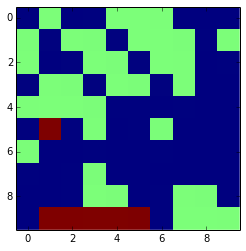

---------------------------------------
total_exp 1798
{'im': {(0, 0) -> (9, 9): -0.025423896317549974,
        (3, 0) -> (9, 9): -0.067149036501208265,
        (5, 0) -> (9, 9): 0.011121414729944074,
        (7, 0) -> (9, 9): -0.082866188307029368,
        (8, 0) -> (9, 9): -0.12749679365611999,
        (9, 0) -> (9, 9): -0.19010433722560194,
        (1, 1) -> (9, 9): -0.05629537604449697,
        (2, 1) -> (9, 9): -0.076151859849152237,
        (5, 1) -> (9, 9): 0.057077204038779888,
        (6, 1) -> (9, 9): 0.066113003703275303,
        (7, 1) -> (9, 9): 0.080986983374321586,
        (8, 1) -> (9, 9): -0.14359731518327989,
        (9, 1) -> (9, 9): -0.22059606872089299,
        (0, 2) -> (9, 9): -0.015532707790582828,
        (2, 2) -> (9, 9): -0.069688546603866808,
        (5, 2) -> (9, 9): 0.10454804047736069,
        (6, 2) -> (9, 9): 0.11993534116852275,
        (7, 2) -> (9, 9): 0.12853022515020679,
        (8, 2) -> (9, 9): -0.085163556412181179,
        (9, 2) -> (9, 9): -0.

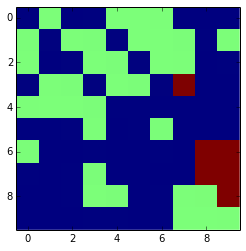

---------------------------------------
total_exp 1873
{'im': {(0, 0) -> (9, 9): -0.038621790728239784,
        (3, 0) -> (9, 9): -0.033649938687290167,
        (5, 0) -> (9, 9): 0.0031513231861839408,
        (7, 0) -> (9, 9): 0.10864268736867953,
        (8, 0) -> (9, 9): 0.019837542703484617,
        (9, 0) -> (9, 9): 0.0096906480644111254,
        (1, 1) -> (9, 9): -0.043862431404224175,
        (2, 1) -> (9, 9): -0.027836922408067819,
        (5, 1) -> (9, 9): 0.0054767696427193702,
        (6, 1) -> (9, 9): -0.029414961527868544,
        (7, 1) -> (9, 9): -0.013971671403448127,
        (8, 1) -> (9, 9): 0.028224204567175684,
        (9, 1) -> (9, 9): 0.047242855825388785,
        (0, 2) -> (9, 9): -0.049464158532514693,
        (2, 2) -> (9, 9): -0.041351806649400899,
        (5, 2) -> (9, 9): -0.0082151207596291576,
        (6, 2) -> (9, 9): -0.013506115092188575,
        (7, 2) -> (9, 9): 0.021621143642287011,
        (8, 2) -> (9, 9): -0.014335124244180569,
        (9, 2) -> (

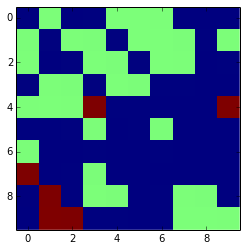

---------------------------------------
total_exp 1894


In [48]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(20):
    meta.run(tasks, num_epochs=1)
    to_show = ['new-tasks-selected', 'im', 'pred', 'ucb']
    pprint({key: meta.diagnostics[key] for key in to_show})
    visualize_tasks(meta.diagnostics['active-tasks'], meta.diagnostics['passive-tasks'])
    print '---------------------------------------'
    if (it + 1) % 1 == 0:
        print 'total_exp', learner.total_exp
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

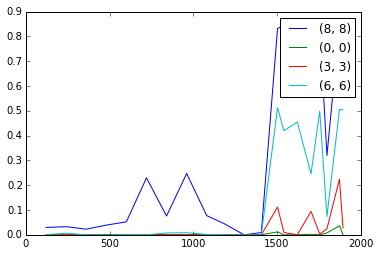

In [49]:
plot_scores()

In [27]:
save_globals('v0a-1', ['exs', 'scores'])

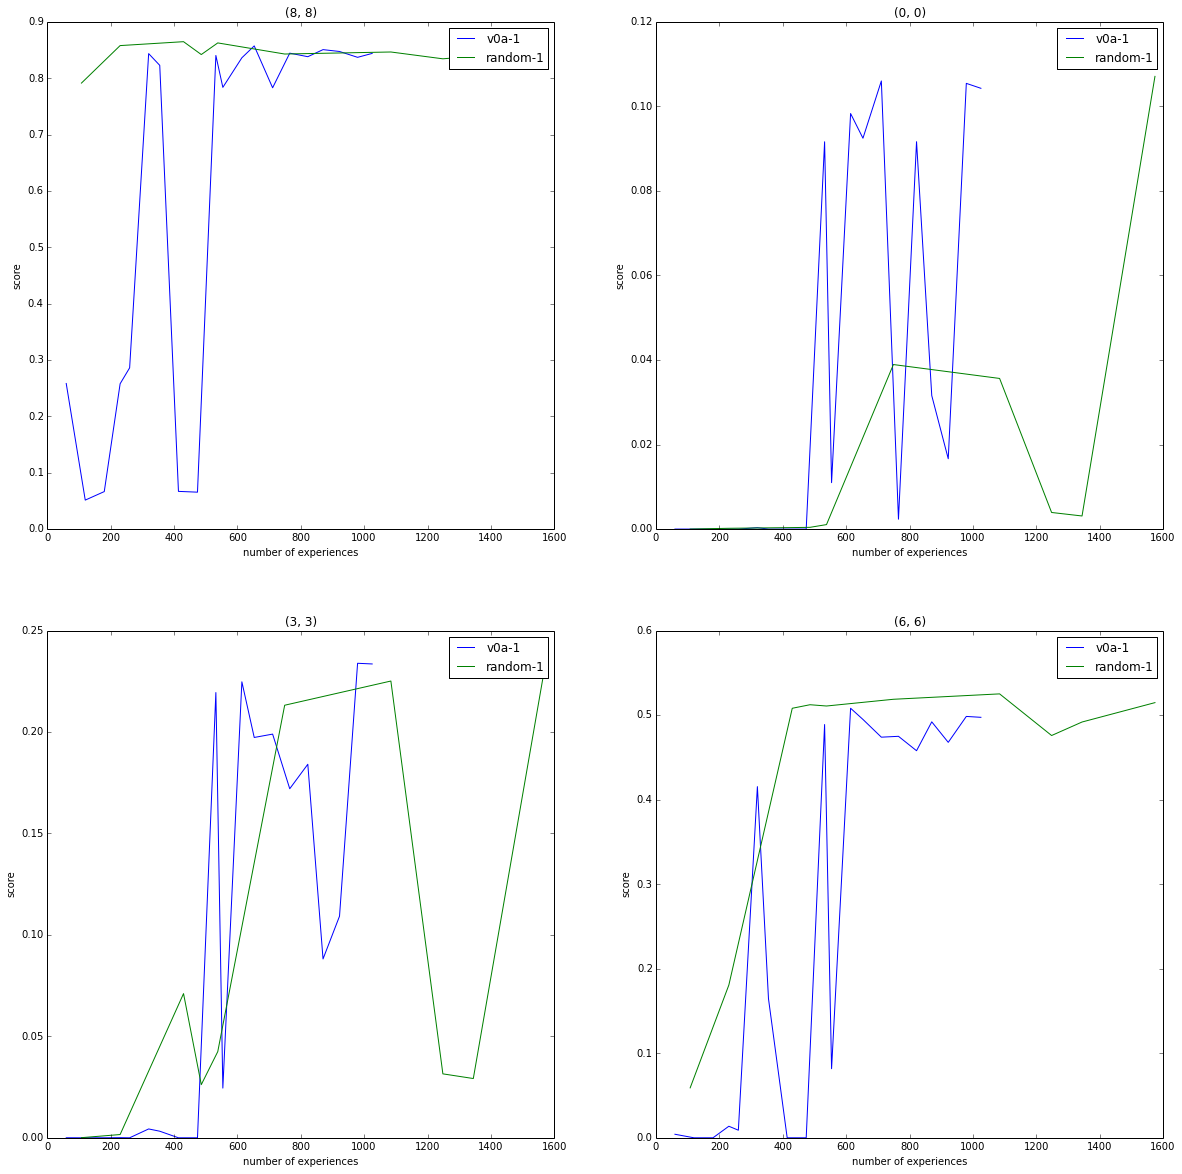

In [45]:
plot_mean_scores(['v0a-1', 'random-1'])

### V1 with DeepQlearnMT

In [46]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)

In [47]:
budget = 5
tol = 1e-4
gamma = 0.9
memory_size = 128
lr = 1e-3

learner = DeepQlearnMT(dqn, gamma=gamma, lr=lr, memory_size=memory_size, epsilon=0.1, update_strategy='task')
train_func = lambda task:  learner.run(task, num_episodes=1, tol=tol, budget=budget)
eval_func = lambda task: qval_stochastic(dqn, task, gamma=gamma, budget=budget, num_trials=100, tol=tol)

In [48]:
meta = GPv1(dqn, kernel_func, expand_func, train_func, eval_func, 
            eta=1e-4, sigma_n=0.1, K=1, K1=1)

In [49]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(100):
    meta.run(tasks, num_epochs=1)
    to_show = ['curr_tasks', 'new-tasks-selected', 'im', 'pred', 'ucb']
    pprint({key: meta.diagnostics[key] for key in to_show})
    print '---------------------------------------'
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

{'curr_tasks': [(8, 8) -> (9, 9), (1, 4) -> (9, 9)],
 'im': {(1, 4) -> (9, 9): 0.0005668179485635329,
        (8, 8) -> (9, 9): 0.1254817883446151},
 'new-tasks-selected': [(8, 8) -> (9, 9)],
 'pred': {(0, 3) -> (9, 9): 7.6430335713116457e-05,
          (1, 3) -> (9, 9): 0.00020775919271198882,
          (2, 3) -> (9, 9): 7.8235822669401011e-05,
          (0, 4) -> (9, 9): 0.00020775919271198882,
          (1, 4) -> (9, 9): 0.00056474803824432005,
          (2, 4) -> (9, 9): 0.00021266701509677698,
          (0, 5) -> (9, 9): 7.8235822669401011e-05,
          (1, 5) -> (9, 9): 0.00021266701509677698,
          (2, 5) -> (9, 9): 9.1576667075275151e-05,
          (7, 7) -> (9, 9): 0.016919936819044603,
          (8, 7) -> (9, 9): 0.045992993587217736,
          (9, 7) -> (9, 9): 0.016919876778667391,
          (7, 8) -> (9, 9): 0.045992993587217736,
          (8, 8) -> (9, 9): 0.12502185866419016,
          (9, 8) -> (9, 9): 0.045992971499597315,
          (7, 9) -> (9, 9): 0.01691987677

KeyboardInterrupt: 

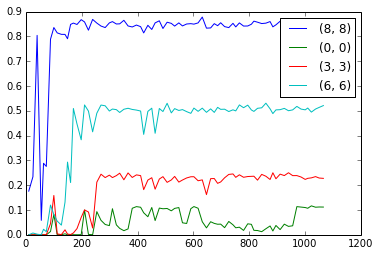

In [50]:
plot_scores()

### V1 with DeepQlearn

In [115]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)

In [97]:
budget = 30
tol = 1e-4
gamma = 0.9
memory_size = 1000
lr = 1e-3

learner = DeepQlearn(dqn, gamma=gamma, lr=lr, memory_size=memory_size, epsilon=0.1)
train_func = lambda task:  learner.run(task, num_episodes=3, tol=tol, budget=budget)
eval_func = lambda task: qval_stochastic(dqn, task, gamma=gamma, budget=budget, num_trials=100, tol=tol)

In [98]:
meta = GPv1(dqn, kernel_func, expand_func, train_func, eval_func, 
            eta=1e-4, sigma_n=0.1, K=1, K1=1, K0=1)

In [99]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(20):
    meta.run(tasks, num_epochs=1)
    to_show = ['new-tasks-selected', 'im', 'pred', 'ucb']
    pprint({key: meta.diagnostics[key] for key in to_show})
    print '---------------------------------------'
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

{'im': {(8, 1) -> (9, 9): -0.00044832134565127941,
        (3, 3) -> (9, 9): -0.00077993654081748472,
        (7, 7) -> (9, 9): 0.0033516662077585288,
        (7, 8) -> (9, 9): -0.0011959926303165662},
 'new-tasks-selected': [(7, 7) -> (9, 9)],
 'pred': {(7, 0) -> (9, 9): -5.8432843810388518e-05,
          (8, 0) -> (9, 9): -0.00016432054715108003,
          (9, 0) -> (9, 9): -6.0450151058924964e-05,
          (7, 1) -> (9, 9): -0.00015883693751496473,
          (8, 1) -> (9, 9): -0.00044666955736322861,
          (9, 1) -> (9, 9): -0.00016432054715108003,
          (2, 2) -> (9, 9): -0.00010551972236994781,
          (3, 2) -> (9, 9): -0.00028683234386227258,
          (4, 2) -> (9, 9): -0.00010716790849240724,
          (7, 2) -> (9, 9): -4.352684738217329e-05,
          (8, 2) -> (9, 9): -0.00015883693751496473,
          (9, 2) -> (9, 9): -5.8432843810388518e-05,
          (2, 3) -> (9, 9): -0.00028587000126349167,
          (3, 3) -> (9, 9): -0.00077707522973611371,
          (4, 

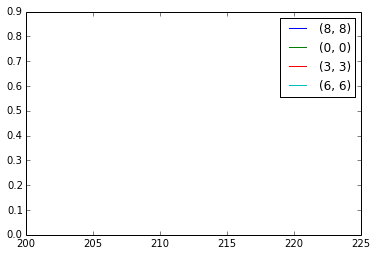

In [114]:
plot_scores()

## Baseline (random start)

In [42]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 128, epsilon=0.1)
scores = []
exs = []
tol = 1e-4
for it in range(10):
    task = prob.choice(tasks, 1)[0]
    learner.run(task, num_episodes=10, tol=tol)
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
    print 'it', it

it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9


In [44]:
save_globals('random-1', ['exs', 'scores'])

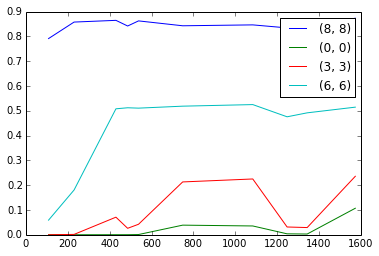

In [43]:
plot_scores()

## Baseline (start from (0,0))

In [35]:
task = test_tasks[0]
dqn = DQN(task, arch_func=two_layer, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 128, epsilon=0.1)
scores = []
exs = []
tol = 1e-4
for it in range(10):
    learner.run(task, num_episodes=10, tol=tol)
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
    print 'it', it




it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9


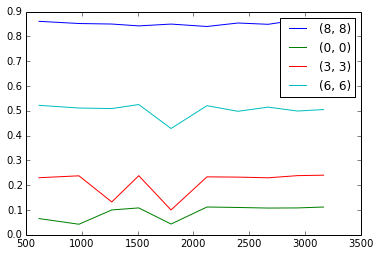

In [36]:
plot_scores()

In [91]:
task = test_tasks[0]
dqn = DQN(task, arch_func=two_layer, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 1280, epsilon=0.1)
scores = []
exs = []
tol = 1e-4
for it in range(10):
    learner.run(task, num_episodes=10, tol=tol)
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
    print 'it', it



it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9


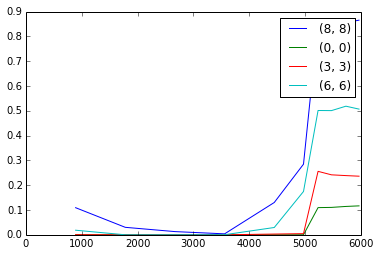

In [92]:
plot_scores()

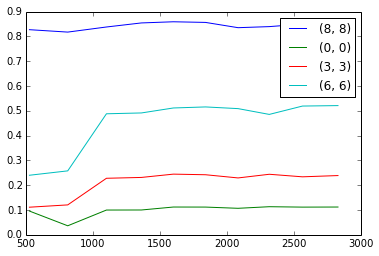

In [52]:
plot_scores()

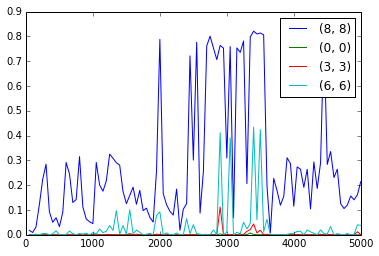

In [19]:
plot_scores()

## Visualization

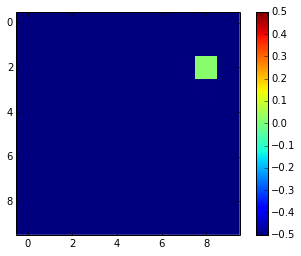

In [138]:

from ipywidgets import widgets, interact

def make_plot(i):
    (loc, im) = (start_locs[i], ims[i])
    grid = np.ones((H, W)) * -1.
    grid[loc] = im
    imshow(grid, interpolation='none', vmin=-.5, vmax=.5)
    colorbar()

interact(make_plot, i=(0,len(ims),1))


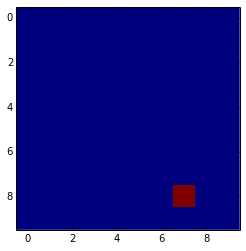

qvals [ 47.99788916  52.20889229  47.69676138  47.72885463]
p [ 0.01430037  0.96419043  0.01058204  0.01092716]
1


KeyboardInterrupt: 

In [100]:
task = test_tasks[3]
print task
task.reset()
while not task.is_end():
    imshow(task.curr_state[0], interpolation='none')
    show()
#     action = dqn.get_action(task.curr_state, method='eps-greedy', epsilon=0., valid_actions=task.valid_actions)
    action = dqn.get_action(task.curr_state, method='softmax', temperature=1e-2, valid_actions=task.valid_actions)
    print action
    sys.stdout.flush()
    task.step(action)
    time.sleep(0.5)
    clear_output()

In [102]:
reward_stochastic(dqn, task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)

0.31843645660734682